# **Python course: Final project**
### ***Flow control by Omar Piedras***
##### *This project implements a Python-based geospatial framework for the hydrological analysis of river basins, focusing on key flow control parameters.The integration of geospatial data processing with numerical computation provides a robust tool for watershed characterization, enabling a more accurate understanding of hydrological behavior, flood potential, and sediment transport dynamics. This approach is essential for effective water resource management and infrastructure planning.*
---

In [42]:
#EXTENSIONS
import folium
import numpy as np 
import pandas as pd 
from scipy import stats 
import geopandas as gpd 
from folium import plugins
from scipy import optimize 
from scipy import integrate 
from matplotlib import pyplot as plt 

In [43]:
#DATA READING
path = "./archivos_proyecto/material_01/"
#FILE NAMES
  #Part I
nombres_coord = ["Coords Río Sonora.shp"]
  #Part II
nombres_sub =  ["RH12Ai_subc.shp","RH19Be_subc.shp"]
nombres_corr = ["RH12Ai_hl.shp", "RH19Be_hl.shp"]
#LISTS TO PLACE THE VARIABLES OF THE FILES
  #Part I
Río = [None]
  #Part II
Cuencas = [None,None]
Corrientes = [None,None]

>### **Sonora river slope**
*This module performs a comprehensive slope analysis of the Sonora River by processing geometric data and applying numerical methods. The process begins by shifting the river's coordinate points to calculate the sequential distance between them, resulting in a cumulative distance profile that defines the longitudinal axis (x). The elevation data (z) is then extracted for these points. The core of the analysis involves defining a compensation line—a straight line that balances the areas above and below the river's profile. This is achieved by using numerical integration (Simpson's rule) and a root-finding algorithm to determine the optimal starting elevation for this line. The code generates a detailed plot visualizing the river profile, the calculated compensation line, and the distinct positive and negative areas between them. Finally, it computes and prints two slope values: the simple average slope and the more accurate compensated areas slope, providing a comparative metric for the river's gradient.*

In [44]:
#UPLOAD INFORMATION
for i in range (len(Río)):
    Río[i]= gpd.read_file(path + nombres_coord[i])
    # Coordinates UTM 12N [m]
    Río[i]= Río[i].to_crs(32612)
# Point cloud with dimension information
Río[0].head(3)

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,COV_,COV_ID,NOMBRES,distance,angle,xcoord,ycoord,zcoord,Distancia,x,geometry
0,426,427,0,0,2.38878,1097,1709,R. Sonora,0.00,190.20399,-109.897192,30.864662,1682,289459.288785,467599.413374,POINT (605432.197 3415123.794)
1,426,427,0,0,2.38878,1097,1709,R. Sonora,0.01,190.20399,-109.898964,30.854820,1606,1118.674332,468718.087706,POINT (605273.576 3414031.328)
2,426,427,0,0,2.38878,1097,1709,R. Sonora,0.02,190.20399,-109.900735,30.844978,1393,1118.683383,469836.771089,POINT (605114.917 3412938.867)


In [60]:
#RIVER VECTOR TO VERIFY LOCATION
Río[0].explore()

#### **Formulas use**
**1. Euclidean distance between consecutive Points**
*To calculate the distance between two consecutive geographic points*
$$d_i = \sqrt{(x_i - x_{i-1})^2 + (y_i - y_{i-1})^2}$$
*where:*
- ***$d_i$***:        distance between the point $i-1$ and $i$
- ***$(x_i, y_i)$***: coordinates of $i$
- ***$(x_{i-1}, y_{i-1})$***: coordinates of the past point
---
**2. Cumulative distance along the river**
*The total distance traveled from the start to point sk*
$$s_k = \sum_{i=1}^{k} d_i$$
*where:*
- ***$s_k$***: cumulative distance to point $k$
- ***$d_i$***: distance between consecutive points
- ***$k$***: index of the current point

In [46]:
# Moving the coordinates one place to perform the calculation
gs = Río[i]["geometry"].shift(1)
# 1) Calculating the distance between two adjacent points
Río[0]["Distance"] = Río[0]["geometry"].distance(gs)
# 2) The position of the first point is 0, for the others it is a cumulative sum
Río[0].loc[0,"Distance"]=0
Río[0]["x"] = Río[0]["Distance"].cumsum()
# Saving the distance and the elevation in other variables
x = Río[0]["x"]
z = Río[0]["zcoord"]
# Choosing the initial and final values
x_i = x.to_numpy()[0]
x_f = x.to_numpy()[-1]
z_i = z.to_numpy()[0]
z_f = z.to_numpy()[-1]
Río[0].head(2)

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,COV_,COV_ID,NOMBRES,distance,angle,xcoord,ycoord,zcoord,Distancia,x,geometry,Distance
0,426,427,0,0,2.38878,1097,1709,R. Sonora,0.00,190.20399,-109.897192,30.864662,1682,289459.288785,0.000000,POINT (605432.197 3415123.794),0.000000
1,426,427,0,0,2.38878,1097,1709,R. Sonora,0.01,190.20399,-109.898964,30.854820,1606,1118.674332,1103.921536,POINT (605273.576 3414031.328),1103.921536


#### **Formulas used**
**3) Compensation Line (`rect_comp`)**
*Equation of the compensation line passing through the end point $(s_f, z_f)$ with slope determined by the reference point $(s_f, z_r)$:*
$$z_{\text{comp}}(s) = \frac{z_f - z_r}{s_f - s_i} \cdot (s - s_f) + z_f$$
*Where:*
- ***$z_{\text{comp}}(s)$***: compensated elevation at distance $s$
- ***$z_r$***: reference elevation for slope calculation
- ***$z_f$***: final elevation of the profile
- ***$s_i$, $s_f$***: initial and final cumulative distances
- ***$s$***: cumulative distance along the river
---
**4) Compensated Area Integral (`area_comp`)**
*Calculation of the area between the real profile and the compensation line using numerical integration:*
$$I = \int_{s_i}^{s_f} \left[ z(s) - z_{\text{comp}}(s) \right]  ds$$
*Where:*
- ***$I$***: compensated area (integral of the difference)
- ***$z(s)$***: real elevation of the longitudinal profile
- ***$z_{\text{comp}}(s)$***: compensation line elevation
- ***$s_i$, $s_f$***: integration limits (initial and final distances)
---
**Numerical Integration Method**

**`Simpson's rule`** *is used for numerical integration:*
$$\int_{a}^{b} f(s)  ds \approx \frac{\Delta s}{3} \left[ f(s_0) + 4f(s_1) + 2f(s_2) + 4f(s_3) + \cdots + 2f(s_{n-2}) + 4f(s_{n-1}) + f(s_n) \right]$$
*Where:*
- ***$\Delta s = \frac{s_f - s_i}{n}$***: spacing between points
- ***$n$***: number of subintervals (even)
- ***$s_0, s_1, \ldots, s_n$***: equidistant points in the interval $[s_i, s_f]$


In [47]:
#DEFINITION OF FUNCTIONS
 # 3) Compensation line
def rect_comp(z_r):
    z = (z_f - z_r ) / (x_f - x_i) * (x - x_f) + z_f
    return z
 # 4) Compensated area integral
def area_comp(z_r):
    a = rect_comp(z_r)
    I = integrate.simpson(z - a)
    return I

══════════════════════════════════════════════════
SONORA RIVER SLOPE ANALYSIS
══════════════════════════════════════════════════
• Average slope method: 4.78 [m/km]
• Compensated areas method: 2.85 [m/km]
• Difference: 1.93 [m/km]
• Relative difference: 40.4%
══════════════════════════════════════════════════


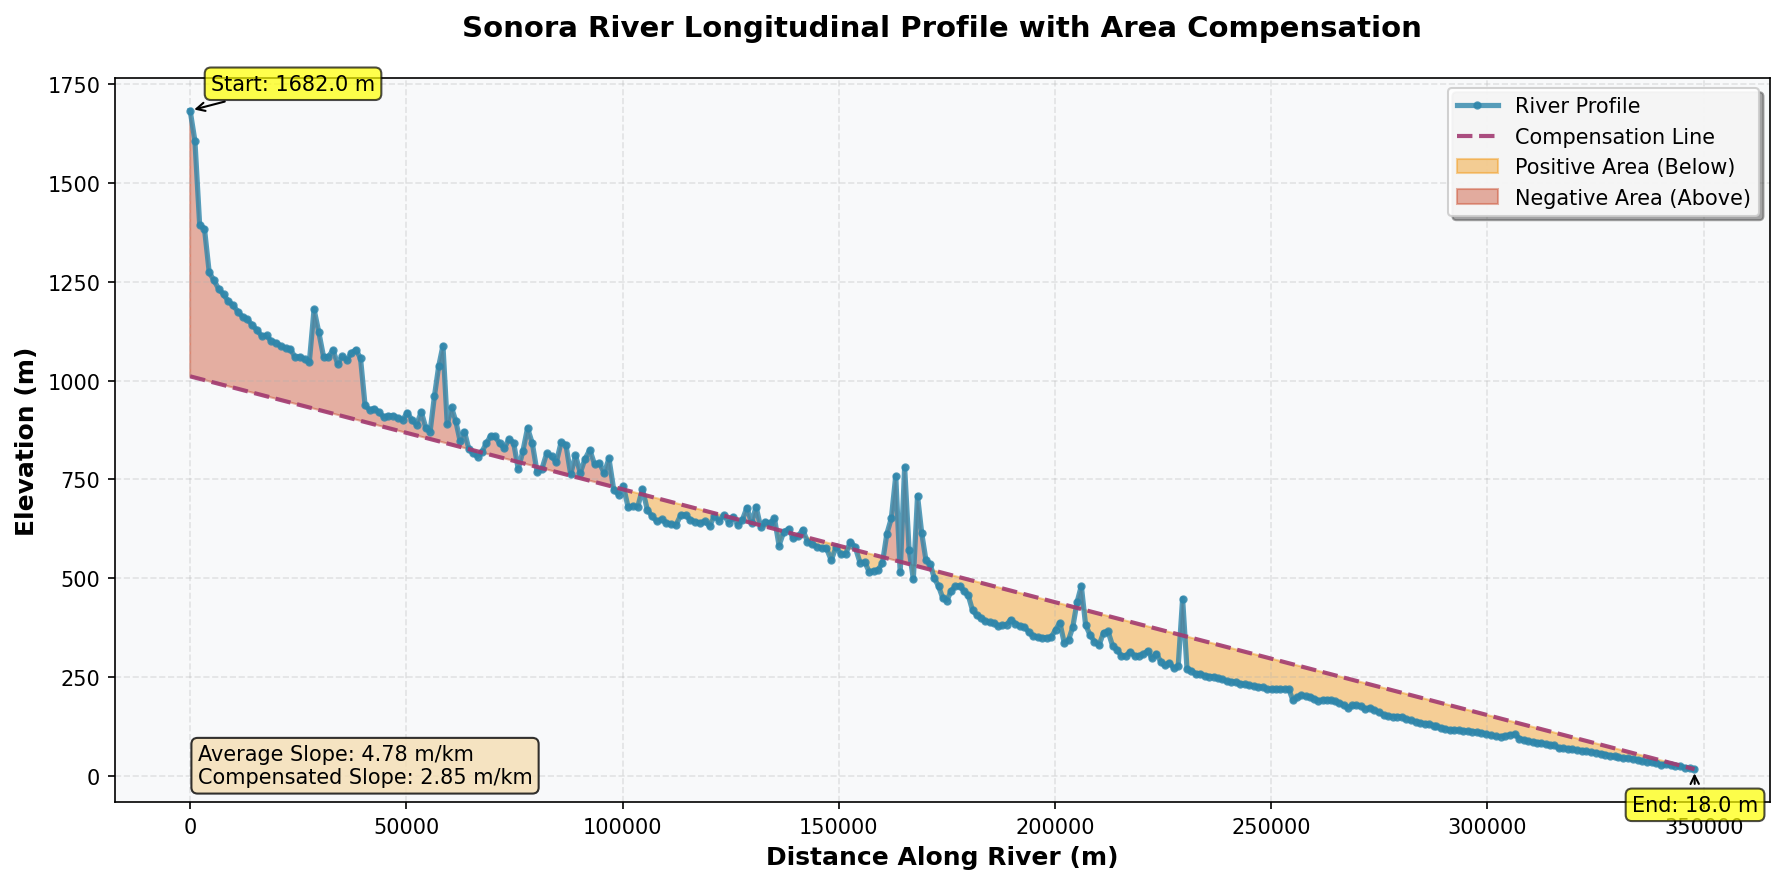

In [48]:
#======================================================================================================================
#CHART
fig, ax = plt.subplots()
fig.set_facecolor("white")
fig.set_size_inches(12, 6)
fig.set_dpi(150)
# River profile
ax.plot(x, z, color='#2E86AB', linewidth=2.5, label='River Profile', marker='o', markersize=3,alpha=0.8)
# Finding the z_r dimension that compensates the areas
z_r = optimize.fsolve(area_comp, x0=z_i)
z_r_result = optimize.fsolve(area_comp, x0=z_i)
z_r = z_r_result[0]  # Extract the scalar value from the array
# Graph the compensated line 
z_2 = rect_comp(z_r)
ax.plot(x, z_2, color='#A23B72', linewidth=2, linestyle='--', label='Compensation Line',alpha=0.9)
# Offset areas
ax.fill_between(x, z, z_2, where=z < z_2, color='#F18F01', alpha=0.4, label='Positive Area (Below)',interpolate=True)
ax.fill_between(x, z, z_2, where=z > z_2, color='#C73E1D', alpha=0.4, label='Negative Area (Above)',interpolate=True)
#======================================================================================================================
# SLOPE CALCULATION METHODS
Sm = abs((z_f - z_i) / (x_f - x_i)) * 1000  # Average slope
Sac = abs((z_f - z_r) / (x_f - x_i)) * 1000  # Compensated areas slope
# Slope information
slope_text = f'Average Slope: {Sm:.2f} m/km\nCompensated Slope: {Sac:.2f} m/km'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.08, slope_text, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
# Grid 
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#F8F9FA')
# Labels and title 
ax.set_xlabel('Distance Along River (m)', fontsize=12, fontweight='bold')
ax.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
ax.set_title('Sonora River Longitudinal Profile with Area Compensation', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', framealpha=0.9, shadow=True)
# Annotations for key points
ax.annotate(f'Start: {z_i:.1f} m', xy=(x_i, z_i), xytext=(10, 10), textcoords='offset points',bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"))
ax.annotate(f'End: {z_f:.1f} m', xy=(x_f, z_f), xytext=(-30, -20), textcoords='offset points',bbox=dict(boxstyle="round,pad=0.3", 
                      facecolor="yellow", alpha=0.7),arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"))
# Tick formatting
ax.tick_params(axis='both', which='major', labelsize=10)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
# Print results 
print("═" * 50)
print("SONORA RIVER SLOPE ANALYSIS")
print("═" * 50)
print(f"• Average slope method: {Sm:.2f} [m/km]")
print(f"• Compensated areas method: {Sac:.2f} [m/km]")
print(f"• Difference: {abs(Sm-Sac):.2f} [m/km]")
print(f"• Relative difference: {abs(Sm-Sac)/Sm*100:.1f}%")
print("═" * 50)
fig.tight_layout()
plt.show()

>### **Stream density, drainage density and basin order**
*This section conducts a detailed hydrological characterization of the RH12Ai and RH19Be subchatchments by calculating key drainage network parameters. The process begins by loading and preprocessing geospatial data for both the subcatchment boundary and its stream network, converting them to a projected coordinate system (UTM 12N) for accurate metric calculations. The core analysis involves computing three fundamental hydrological metrics: Stream Density, calculated as the total number of perennial and intermittent streams per square kilometer; Drainage Density, derived from the total length of all stream segments divided by the sub-catchment area; and the Maximum Stream Order according to the Strahler hierarchy method, which identifies the highest branching complexity within the network. The code efficiently filters and aggregates stream data by flow condition (perennial/intermittent) to provide a comprehensive summary of the basin's drainage structure, outputting both the calculated metrics and detailed auxiliary information for hydrological assessment.*

#### **Formulas used**
**Stream Density** ($D_s$)
*Measures how many stream channels exist per unit area. Higher values indicate more developed drainage networks, often found in areas with high rainfall or easily erodible rocks.*

$$D_s = \frac{N_s}{A_c}$$
*Where:*
- ***$D_s$***: stream density [streams/km²]
- ***$N_s$***: total number of perennial and intermittent streams
- ***$A_c$***: subcatchment area [km²]
---
**Drainage Density** ($D_d$)
*Represents the total length of streams per unit area. High drainage density indicates efficient water removal, typical in steep terrain with impermeable surfaces. Low values suggest flat areas or permeable soils.*
$$D_d = \frac{L_s}{A_c}$$
*Where:*
- ***$D_d$***: drainage density [km/km²]
- ***$L_s$***: total length of all streams [km]
- ***$A_c$***: subcatchment area [km²]
---
**Maximum Stream Order** ($O_{\text{max}}$)
*Identifies the highest hierarchy level in the stream network using Strahler's method. Larger values indicate more complex and developed drainage systems. First-order streams are headwaters; higher orders represent larger tributaries and main channels.*
$$O_{\text{max}} = \max(\text{ORDER}_1)$$
*Where:*
- ***$O_{\text{max}}$***: highest Strahler stream order in the network
- ***$\text{ORDER}_1$***: stream order values for all segments
---
**Stream Length Composition**
*Total length calculations help understand the spatial extent of the drainage network. Perennial streams flow year-round, while intermittent streams flow seasonally, indicating different groundwater contributions and hydrological regimes.*
$$L_{\text{total}} = \sum L_i$$
$$L_{\text{perennial}} = \sum L_{\text{perennial streams}}$$
$$L_{\text{intermittent}} = \sum L_{\text{intermittent streams}}$$

---
**Average Stream Length** ($L_{\text{avg}}$)
*Provides the typical length of stream segments in the network. Shorter average lengths may indicate more dissected terrain, while longer averages suggest more continuous flow paths.*
$$L_{\text{avg}} = \frac{\sum_{i=1}^{N_s} L_i}{N_s}$$
*Where:*
- ***$L_{\text{avg}}$***: mean length of streams [km]
- ***$L_i$***: length of individual stream segment $i$
- ***$N_s$***: total number of streams

**`Subcatchment/Subbasin RH12Ai`**

In [49]:
#VISUALIZATION
i = 0
Cuencas[i]= gpd.read_file(path+nombres_sub[i])
gdf_RH12Ai = Cuencas[i]
Cuencas[i].explore()

In [50]:
#OPEN GEOSPATIAL INFORMATION OF THE SUBCATCHMENT
i = 0
Cuencas[i]= gpd.read_file(path+nombres_sub[i])
 #Conversion to coordinates UTM 12N [m] ---> EPSG:32612
Cuencas[i]=Cuencas[i].to_crs(32612)
 #Print
gdfA = Cuencas[i]
gdfA = gdfA.reindex(columns= ["ID","RH","CUENCA","CVE_SUBCUE","SUBCUENCA","AREA_KM2","PERIMETRO","TIPO","geometry"])
gdfA = gdfA.set_index("ID") 
gdfA

,RH,CUENCA,CVE_SUBCUE,SUBCUENCA,AREA_KM2,PERIMETRO,TIPO,geometry
ID,,,,,,,,
303.0,LERMA - SANTIAGO,R. LERMA - TOLUCA,RH12Ai,R. Gavia,579.87,119.92,ABIERTA,"POLYGON ((1692637.812 2178673.406, 1692623.71 ..."


In [51]:
#OPEN INFORMATION ON THE STREAMS OF SUBCATCHMENT
i = 0
Corrientes[i] = gpd.read_file(path+nombres_corr[i])
 #Conversion to coordinates UTM 12N [m] ---> EPSG:32612
Corrientes[i] = Corrientes[i].to_crs(32612)
 #Print
gdf1 = Corrientes[i]
gdfCa = gdf1.reindex(columns= ["ID","CVE_SUBC","CLAVE50K","FC","ENTIDAD","CONDICION","LENGTHM","FLOWDIR","ORDER_1","LEVEL_1","FECHA"])
gdfCa = gdfCa.set_index("ID") 
gdfCa.head(3)

,CVE_SUBC,CLAVE50K,FC,ENTIDAD,CONDICION,LENGTHM,FLOWDIR,ORDER_1,LEVEL_1,FECHA
ID,,,,,,,,,,
6283246,RH12Ai,e14a37,3271,CORRIENTE DE AGUA,INTERMITENTE,99.4970,1,3,3,1996-01-31
6283247,RH12Ai,e14a37,3271,CORRIENTE DE AGUA,INTERMITENTE,238.5890,1,2,3,1996-01-31
6283248,RH12Ai,e14a37,3272,CORRIENTE DE AGUA,PERENNE,119.6795,1,6,1,1996-01-31


In [52]:
#HYDROLOGICAL PARAMETERS CALCULATION
#======================================================================================================================
subcatchment_area = np.array(gdfA["AREA_KM2"])
#------------------------------------------------------------------------------
#STREAM DENSITY CALCULATION -> Ds = Ns / Ac
 #Get perennial and intermittent streams
perennial_streams = gdfCa[gdfCa["CONDICION"] == "PERENNE"]
intermittent_streams = gdfCa[gdfCa["CONDICION"] == "INTERMITENTE"]
 #Calculate total number of streams
total_streams = len(perennial_streams) + len(intermittent_streams)
 #Calculate stream density
stream_density = total_streams / subcatchment_area
#------------------------------------------------------------------------------
#DRAINAGE DENSITY CALCULATION -> Dd = Ls / Ac
 #Calculate total stream length in meters and convert to kilometers
total_length_m = gdfCa["LENGTHM"].sum()
total_length_km = total_length_m / 1000
 #Calculate drainage density
drainage_density = total_length_km / subcatchment_area
#------------------------------------------------------------------------------
#STREAM ORDER CALCULATION
max_stream_order = gdfCa["ORDER_1"].max()
#------------------------------------------------------------------------------
# RESULTS OUTPUT
print("=" * 50)
print("SUBCATCHMENT RH12Ai - HYDROLOGICAL ANALYSIS")
print("=" * 50)
print(f"• Subcatchment area: {subcatchment_area[0]:.2f} km²")
print(f"• Total streams: {total_streams}")
print(f"  - Perennial streams: {len(perennial_streams)}")
print(f"  - Intermittent streams: {len(intermittent_streams)}")
print(f"• Stream density: {stream_density[0]:.4f} [streams/km²]")
print(f"• Total stream length: {total_length_km:.2f} km")
print(f"• Drainage density: {drainage_density[0]:.4f} [km/km²]")
print(f"• Maximum stream order: {max_stream_order}")
print("=" * 50)
# Additional detailed information
print("DETAILED STREAM INFORMATION:")
print(f"• Perennial streams length: {perennial_streams['LENGTHM'].sum()/1000:.2f} km")
print(f"• Intermittent streams length: {intermittent_streams['LENGTHM'].sum()/1000:.2f} km")
print(f"• Average stream length: {total_length_m/len(gdfCa)/1000:.2f} km")
# Return calculated values as dictionary for further use
hydrological_parameters = {'subcatchment_area_km2': subcatchment_area[0],'total_streams': total_streams,
    'perennial_streams': len(perennial_streams),'intermittent_streams': len(intermittent_streams),
    'stream_density': stream_density[0],'total_length_km': total_length_km,'drainage_density': drainage_density[0],
    'max_stream_order': max_stream_order}

SUBCATCHMENT RH12Ai - HYDROLOGICAL ANALYSIS
• Subcatchment area: 579.87 km²
• Total streams: 2886
  - Perennial streams: 492
  - Intermittent streams: 2394
• Stream density: 4.9770 [streams/km²]
• Total stream length: 1474.05 km
• Drainage density: 2.5420 [km/km²]
• Maximum stream order: 6
DETAILED STREAM INFORMATION:
• Perennial streams length: 235.51 km
• Intermittent streams length: 1176.92 km
• Average stream length: 0.46 km


**`Subcatchment/Subbasin RH19Be`**

In [53]:
#VISUALIZATION
i = 1
Cuencas[i]= gpd.read_file(path+nombres_sub[i])
gdf_RH19Be = Cuencas[i]
Cuencas[i].explore()

In [54]:
#OPEN GEOSPATIAL INFORMATION OF THE SUBCATCHMENT
i = 1
Cuencas[i]= gpd.read_file(path+nombres_sub[i])
 #Conversion to coordinates UTM 12N [m] ---> EPSG:32612
Cuencas[i]=Cuencas[i].to_crs(32612)
 #Print
gdfB = Cuencas[i]
gdfB = gdfB.reindex(columns= ["ID","RH","CUENCA","CVE_SUBCUE","SUBCUENCA","AREA_KM2","PERIMETRO","TIPO","geometry"])
gdfB = gdfB.set_index("ID") 
gdfB

,RH,CUENCA,CVE_SUBCUE,SUBCUENCA,AREA_KM2,PERIMETRO,TIPO,geometry
ID,,,,,,,,
155.0,COSTA GRANDE,R. COYUQUILLA Y OTROS,RH19Be,R. Petatlán,548.64,142.88,ABIERTA,"POLYGON ((1568699.662 1992272.399, 1568659.436..."


In [55]:
#OPEN INFORMATION ON THE STREAMS OF SUBCATCHMENT
i = 1
Corrientes[i] = gpd.read_file(path+nombres_corr[i])
 #Conversion to coordinates UTM 12N [m] ---> EPSG:32612
Corrientes[i] = Corrientes[i].to_crs(32612)
 #Print
gdf2 = Corrientes[i]
gdfCb = gdf2.reindex(columns= ["ID","CVE_SUBC","CLAVE50K","FC","ENTIDAD","CONDICION","LENGTHM","FLOWDIR","ORDER_1","LEVEL_1","FECHA"])
gdfCb = gdfCb.set_index("ID") 
gdfCb.head(3)

,CVE_SUBC,CLAVE50K,FC,ENTIDAD,CONDICION,LENGTHM,FLOWDIR,ORDER_1,LEVEL_1,FECHA
ID,,,,,,,,,,
2799811,RH19Be,e14c13,3271,CORRIENTE DE AGUA,INTERMITENTE,1434.8164,1,1,3,1998-07-31
2799812,RH19Be,e14c23,3271,CORRIENTE DE AGUA,INTERMITENTE,306.1748,1,2,4,1998-08-31
2799813,RH19Be,e14c14,3271,CORRIENTE DE AGUA,INTERMITENTE,1234.8576,1,1,2,2000-04-30


In [56]:
#HYDROLOGICAL PARAMETERS CALCULATION
#======================================================================================================================
subcatchment_area = np.array(gdfB["AREA_KM2"])
#------------------------------------------------------------------------------
#STREAM DENSITY CALCULATION -> Ds = Ns / Ac
 #Get perennial and intermittent streams
perennial_streams = gdfCb[gdfCb["CONDICION"] == "PERENNE"]
intermittent_streams = gdfCb[gdfCb["CONDICION"] == "INTERMITENTE"]
 #Calculate total number of streams
total_streams = len(perennial_streams) + len(intermittent_streams)
 #Calculate stream density
stream_density = total_streams / subcatchment_area
#------------------------------------------------------------------------------
#DRAINAGE DENSITY CALCULATION -> Dd = Ls / Ac
 #Calculate total stream length in meters and convert to kilometers
total_length_m = gdfCb["LENGTHM"].sum()
total_length_km = total_length_m / 1000
 #Calculate drainage density
drainage_density = total_length_km / subcatchment_area
#------------------------------------------------------------------------------
#STREAM ORDER CALCULATION
max_stream_order = gdfCb["ORDER_1"].max()
#------------------------------------------------------------------------------
# RESULTS OUTPUT
print("=" * 50)
print("SUBCATCHMENT RH19Be - HYDROLOGICAL ANALYSIS")
print("=" * 50)
print(f"• Subcatchment area: {subcatchment_area[0]:.2f} km²")
print(f"• Total streams: {total_streams}")
print(f"  - Perennial streams: {len(perennial_streams)}")
print(f"  - Intermittent streams: {len(intermittent_streams)}")
print(f"• Stream density: {stream_density[0]:.4f} [streams/km²]")
print(f"• Total stream length: {total_length_km:.2f} km")
print(f"• Drainage density: {drainage_density[0]:.4f} [km/km²]")
print(f"• Maximum stream order: {max_stream_order}")
print("=" * 50)
# Additional detailed information
print("DETAILED STREAM INFORMATION:")
print(f"• Perennial streams length: {perennial_streams['LENGTHM'].sum()/1000:.2f} km")
print(f"• Intermittent streams length: {intermittent_streams['LENGTHM'].sum()/1000:.2f} km")
print(f"• Average stream length: {total_length_m/len(gdfCb)/1000:.2f} km")
# Return calculated values as dictionary for further use
hydrological_parameters = {'subcatchment_area_km2': subcatchment_area[0],'total_streams': total_streams,
    'perennial_streams': len(perennial_streams),'intermittent_streams': len(intermittent_streams),
    'stream_density': stream_density[0],'total_length_km': total_length_km,'drainage_density': drainage_density[0],
    'max_stream_order': max_stream_order}

SUBCATCHMENT RH19Be - HYDROLOGICAL ANALYSIS
• Subcatchment area: 548.64 km²
• Total streams: 1166
  - Perennial streams: 168
  - Intermittent streams: 998
• Stream density: 2.1253 [streams/km²]
• Total stream length: 1058.42 km
• Drainage density: 1.9292 [km/km²]
• Maximum stream order: 5
DETAILED STREAM INFORMATION:
• Perennial streams length: 100.52 km
• Intermittent streams length: 957.44 km
• Average stream length: 0.91 km


>### **Interactive map**
*This section generates a professional interactive map to compare two hydrological subcatchments. It uses the Folium library to create a web-based map centered on the first subcatchment's location.
Each subcatchment is added as a distinct layer with custom green and blue styling, transparency, and interactive tooltips that display key metrics like area and name on hover. The map includes essential plugins for usability: a minimap for navigation, a fullscreen button, and a tool for measuring distances and areas directly on the map.*

In [57]:
# MAP
map = folium.Map(location=[gdf_RH12Ai.centroid.y.mean(), gdf_RH12Ai.centroid.x.mean()], zoom_start= 7, tiles='OpenStreetMap')
# First subcatchment
folium.GeoJson(gdf_RH12Ai,name="🟢 Subcatchment RH12Ai",
style_function=lambda x: {'fillColor': '#2E8B57','color': '#006400','weight': 3,'fillOpacity': 0.4}, 
    tooltip=folium.GeoJsonTooltip(fields=['CVE_SUBCUE', 'AREA_KM2'], aliases=['Subcatchment:', 'Area (km²):']), 
     popup=folium.GeoJsonPopup(fields=['CVE_SUBCUE', 'SUBCUENCA', 'AREA_KM2', 'PERIMETRO'],
                             aliases=['ID:', 'Name:', 'Area:', 'Perimeter:'])).add_to(map)
# Second subcatchment
folium.GeoJson(gdf_RH19Be,name="🔵 Subcatchment RH19Be",
style_function=lambda x: {'fillColor': '#4169E1','color': '#00008B','weight': 3,'fillOpacity': 0.4},
    tooltip=folium.GeoJsonTooltip(fields=['CVE_SUBCUE', 'AREA_KM2'], aliases=['Subcatchment:', 'Area (km²):']),
    popup=folium.GeoJsonPopup(fields=['CVE_SUBCUE', 'SUBCUENCA', 'AREA_KM2', 'PERIMETRO'],
                             aliases=['ID:', 'Name:', 'Area:', 'Perimeter:'])).add_to(map)
folium.LayerControl().add_to(map)
plugins.MiniMap().add_to(map)
plugins.Fullscreen().add_to(map)
plugins.MeasureControl(position='bottomleft').add_to(map)
title_html = '''
             <div style="position: fixed; 
                         top: 10px; left: 50px; width: 300px; 
                         background-color: white; padding: 10px;
                         border: 2px solid grey; z-index: 9999;
                         border-radius: 5px;">
                 <h4 style="margin: 0; text-align: center;">
                 🗺️ Subcatchments Comparison
                 </h4>
             </div>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

C:\Users\Omar\AppData\Local\Temp\ipykernel_20172\688045063.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map = folium.Map(location=[gdf_RH12Ai.centroid.y.mean(), gdf_RH12Ai.centroid.x.mean()], zoom_start= 7, tiles='OpenStreetMap')


>### **References used**
- Chow, V., Maidment, R., & Larry, W. (1988). Mays. Applied Hydrology. International edition, MacGraw-Hill.
- Strahler, A. (1957). Quantitative analysis of watershed geomorphology. Eos, *Transactions American Geophysical Union*, 38(6), 913-920.
- Viessman, W., Lewis, G., Knapp, W., & Harbaugh, E. (1989). Introduction to hydrology. Pearson Education.